# Semantic Search in Articles using NLP

## Description

• Write a pipeline of searching some of words in English articles then extract
hot keywords.

• You can split your data to testing, training, validation.

• Do pre-processing on the data just to be able to run it.

• Do optimization time for article to extract the relevant words.

• Feel free to use any technique of feature extraction.

• You can use Deep Learning Methods and show the diff and which one the best. (optional)

## What to turn in:

1. Project documentation (details given below)

2. Report any resource you use

3. Your source code Jupyter Notebook with comments

## Project Documentation:

Please ensure that the documentation is easy to read and follow. Python output
presented as an unformatted screen dump is not acceptable. Do not include code
in the documentation. Provide suﬀicient details for the reader to understand
your process and reproduce your results or something similar. Vague statements
like “I’ve used a Weka filter” without specifying which filter are not acceptable.
It’s preferable to focus on technicalities rather than implementation details.

#### Document Structure:

1. Introduction: State the problem and your objectives

2. Data description: Describe the dataset (number of instances, features, division between training and testing, etc.)

3. Baseline experiments: State the goal, present experiments, and provide
conclusions

4. Other experiments: For each, include goal, steps, results, and conclusion

5. Overall conclusion

#### Additional Requirements:

• List tools used (you may use any tool or programming language you’re
comfortable with)

• List any external resources used

• Include captioned tables for clarity

• Compare your results to previously obtained benchmarks when possible

## Reflection Questions:

After completing your experiments, answer the following: 

1. What was the biggest challenge you faced during this project? 

2. What do you think you have learned from the project?

# Data Acquisition

Link: [Movies Similarity](https://www.kaggle.com/datasets/devendra45/movies-similarity)

Dataset includes the following features:

features: Description

- `rank`:	The rank of the movie, possibly based on some rating or popularity metric.
- `title`: The title of the movie.
- `genre`: The genre(s) of the movie, such as Action, Comedy, Drama, etc.
- `wiki_plot`: The plot summary of the movie extracted from Wikipedia.
- `imdb_plot`: The plot summary of the movie extracted from IMDb.

We will `focus` primarily on the `wiki_plot and imdb_plot features`, as these contain the textual data necessary for semantic search. 

The `title and genre` can also be useful for additional context or filtering but are `not the main focus`.

import libraries

In [1]:
# Machine learning model
import pandas as pd
import matplotlib.pyplot as plt
# !pip install wordcloud
# from wordcloud import WordCloud
import string
import spacy  # cleaning and tokenization
import re
import gensim # load corpora, LSI model and Tf-IDF tokenizer
from operator import itemgetter
from typing import List, Dict
import numpy as np
import joblib

# pretrained model
# !pip install -U sentence-transformers
# from sentence_transformers import SentenceTransformer, util
import os
import csv
import time
import torch

Load dataset

In [3]:
df = pd.read_csv(r"datasets/movies.csv")
df.head()

,rank,title,genre,wiki_plot,imdb_plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1..."


# Data Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rank       100 non-null    int64 
 1   title      100 non-null    object
 2   genre      100 non-null    object
 3   wiki_plot  100 non-null    object
 4   imdb_plot  90 non-null     object
dtypes: int64(1), object(4)
memory usage: 4.0+ KB


we have missing values in column `imdb_plot`, drop them

In [5]:
df.isna().sum()

rank          0
title         0
genre         0
wiki_plot     0
imdb_plot    10
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.isna().sum()

rank         0
title        0
genre        0
wiki_plot    0
imdb_plot    0
dtype: int64

check text columns

In [8]:
df.describe(include='object')

,title,genre,wiki_plot,imdb_plot
count,90,90,90,90
unique,90,57,90,90
top,The Godfather,[u' Drama'],"On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t..."
freq,1,10,1,1


good haven't duplicate values in importance columns `title`, `wiki_plot` and `imdb_plot`

Let's play with some plots word clouds for `wiki_plot` and `imdb_plot`

Concatenate all text data for word cloud generation

In [8]:
def plot_wordcloud(text, title):
    """
    Generates and displays a word cloud visualization for the given text.
    The word cloud is a visual representation where the size of each word corresponds to its frequency or importance in the text. 
    This function uses the `WordCloud` class from the `wordcloud` library to create the visualization and `matplotlib` to display it.

    Args:
        text (str): The input text for which the word cloud will be generated. This should be a single string where all the text is concatenated.
        title (str): The title of the word cloud plot. This title will be displayed above the word cloud.

    Returns:
        None: The function does not return any value. It displays the word cloud plot directly.
    """
    
    wordcloud = WordCloud(width=800, 
                          height=400, 
                          background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

wiki_plot_text = ' '.join(df['wiki_plot'])
imdb_plot_text = ' '.join(df['imdb_plot'])

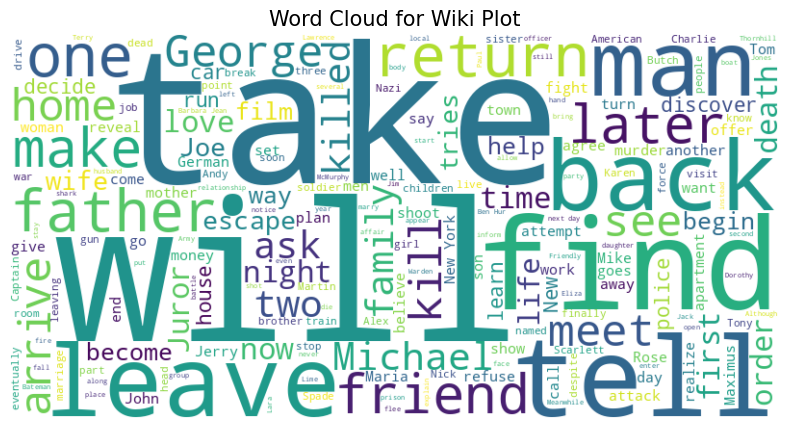

In [9]:
plot_wordcloud(wiki_plot_text, 'Word Cloud for Wiki Plot')

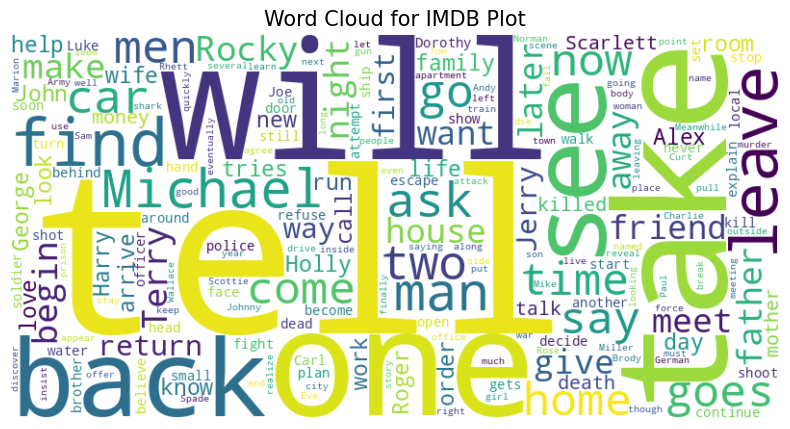

In [10]:
plot_wordcloud(imdb_plot_text, 'Word Cloud for IMDB Plot')

# Data Preprocessing

#### Data cleaning

Apply regular expression for matching patterns of unwanted text and removing/replacing them

apply `spacy_tokenizer` function to column `wiki_plot` and `imdb_plot` column

In [9]:
spacy_nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def spacy_tokenizer(sentence):
    """
    Tokenizes and preprocesses a given sentence using spaCy.

    The function performs the following steps:
    1. Removes distracting single quotes.
    2. Removes digits and words containing digits.
    3. Replaces multiple spaces with a single space.
    4. Removes unwanted lines starting from special characters and non-breaking new line characters.
    5. Removes punctuations.
    6. Tokenizes the sentence using spaCy.
    7. Converts tokens to lowercase, strips whitespace, and lemmatizes words.
    8. Removes stopwords, punctuations, and words with fewer than 3 characters.

    Args:
        sentence (str): The input sentence to be tokenized and processed.

    Returns:
        List[str]: A list of processed tokens from the input sentence.
    """ 
    # remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    # remove digits and words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    # replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    # remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)
    
    # remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)
    
    # remove punctunations
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    
    # apply tokenization
    tokens = spacy_nlp(sentence)
    
    # apply lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    
    # remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    return tokens

df['wiki_plot_tokenized'] = df['wiki_plot'].astype(str).apply(spacy_tokenizer)
df['imdb_plot_tokenized'] = df['imdb_plot'].astype(str).apply(spacy_tokenizer)
df.head()

,rank,title,genre,wiki_plot,imdb_plot,wiki_plot_tokenized,imdb_plot_tokenized
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","[day, daughter, wedding, vito, corleone, hear,...","[late, summer, guest, gather, wedding, recepti..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","[banker, andy, dufresne, convict, murder, wife...","[andy, dufresne, tim, robbins, banker, maine, ..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"[germans, polish, jews, kraków, ghetto, world,...","[relocation, polish, jews, surround, area, kra..."
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","[brief, scene, age, overweight, italian, ameri...","[film, open, old, fat, jake, lamotta, robert, ..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...","[early, december, american, expatriate, rick, ...","[early, year, world, war, december, moroccan, ..."


In [10]:
tokenized = df['wiki_plot_tokenized'] + df['imdb_plot_tokenized']
tokenized[:3]

0    [day, daughter, wedding, vito, corleone, hear,...
1    [banker, andy, dufresne, convict, murder, wife...
2    [germans, polish, jews, kraków, ghetto, world,...
dtype: object

#### Build Word Dictionary

we will build the vocabulary of the corpus which all the unique words are given unique integer ID and to track the frequency of each word, and remove stoplist.

this step is fundamental for converting text data into numerical data

In [11]:
dictionary = gensim.corpora.Dictionary(tokenized)
stoplist = set('hello and if this can would should could tell ask stop come go')
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)

print top 50 items from the dictionary with their unique token-id

In [12]:
dict_tokens_wiki_imdb = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 50]]
dict_tokens_wiki_imdb[0][:5]

[['abduct', 0], ['abe', 1], ['abrasive', 2], ['abroad', 3], ['absence', 4]]

#### Feature Extraction (Bag of Words)

A bag of words model, or BoW for short is a way of extracting features from text for use in modelling.

- It involves two things

    1. A vocabulary of unique tokens assigned a unique id

    2. A measure of the presence of unique words that count each token in the vocabulary

- The `doc2bow method` of dictionary: Convert the `tokenized` documents to a `bag-of-words` whcih iterates through all the words in the text, 

    - if the word already exists in the corpus, it increments the frequency count 
    
    - otherwise it inserts the word into the corpus and sets it freqeuncy count to 1

Each word in the document is `replaced by its unique identifier` and the `count of its occurrences` in that document, return as `tuple` 


(unique id, count of its occurrences)

In [13]:
corpus = [dictionary.doc2bow(desc) for desc in tokenized]
corpus[0][:5]

[(0, 1), (1, 1), (2, 2), (3, 2), (4, 1)]

now replace `token id` with `actual word` in first three documents

(actual word, count of occurrences)

In [14]:
word_frequencies_first_3_doc = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]
word_frequencies_first_3_doc[0][:5]

[('abduct', 1), ('abe', 1), ('abrasive', 2), ('abroad', 2), ('absence', 1)]

# Build Pipeline Machine Learning Model

+ Build the `pipeline`

    - makes it easier to train and evaluate the model

    - which allows you to reuse same preprocessing, tokenizing and testing steps on new data without retrain steps


+ Term Frequency Inverse Document Frequency `(TFIDF) Model`
    - Using the model from `genism` we can determine the most important words in each document in the corpus. 

+ `LSI Model`

    - Once the Tf-Idf model is built, we pass it to LSI model. 
    - Specify the num of features to build pipline which contians on TF-IDF with LSI

In [15]:
tfidf_model = gensim.models.TfidfModel(corpus, 
                                       id2word=dictionary)
lsi_model = gensim.models.LsiModel(tfidf_model[corpus], 
                                   id2word=dictionary, 
                                   num_topics=300)

Serialize and Store the corpus locally for easy retrival whenver required with needing to recompute.

In [16]:
gensim.corpora.MmCorpus.serialize('tfidf_model_mm', 
                                  tfidf_model[corpus])
gensim.corpora.MmCorpus.serialize('lsi_model_mm',
                                  lsi_model[tfidf_model[corpus]])

Load serialized corpus corpus

In [17]:
tfidf_corpus = gensim.corpora.MmCorpus('tfidf_model_mm')
lsi_corpus = gensim.corpora.MmCorpus('lsi_model_mm')

Load the MatrixSimilarity

`Create an index` for similarity queries using the `LSI corpus`

This index will allow us to `find the most similar documents` to a given query.

In [18]:
index = gensim.similarities.MatrixSimilarity(lsi_corpus, 
                               num_features = lsi_corpus.num_terms)

#### Build Semantic Search

We will input a search query and model will return relevant movie titles with "Relevance %" which is the similarity score. The higher the similarity score, the more similar the query to the documetn at the given index

In [19]:
def search_similar_movies(search_term):
    """
    Searches for movies similar to the given search term and returns the top 5 most relevant results.
    
    Args:
        search_term (str): The search query.
    
    Returns:
        pd.DataFrame: A DataFrame containing the top 5 most relevant movies.
    """
    # Tokenize and Convert to Bag-of-Words (BoW)
    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    # Transform BoW to TF-IDF
    bow_tfidf = tfidf_model[query_bow]
    # Transform TF-IDF to LSI
    tfidf_lsi = lsi_model[bow_tfidf]
    index.num_best = 5

    movies_list = index[tfidf_lsi]
    movies_list.sort(key=itemgetter(1), reverse=True)
    movie_names = []

    for j, movie in enumerate(movies_list):

        movie_names.append (
            {
                'Relevance': round((movie[1] * 100),2),
                'Movie Title': df['title'][movie[0]],
                'Movie Plot': df['wiki_plot'][movie[0]]
            }
        )
        if j == (index.num_best-1):
            break
    return pd.DataFrame(movie_names, columns=['Relevance','Movie Title','Movie Plot'])


# Model Evaluation

In [59]:
def average_precision(retrieved: List[str], relevant: List[str]):
    """
    Compute Average Precision.
    
    Args:
        retrieved (List[str]): List of retrieved movie titles.
        relevant (List[str]): List of relevant movie titles.
        
    Returns:
        float: Average precision.
    """
    retrieved_set = set(retrieved)
    relevant_set = set(relevant)
    relevant_count = 0
    precision_sum = 0.0
    
    for i, doc in enumerate(retrieved):
        if doc in relevant_set:
            relevant_count += 1
            precision_sum += relevant_count / (i + 1)
    
    return precision_sum / len(relevant_set) if relevant_set else 0.0

def mean_average_precision(queries: Dict[str, List[str]], k: int):
    """
    Compute Mean Average Precision.
    
    Args:
        queries (Dict[str, List[str]]): Dictionary of queries and relevant documents.
        k (int): Number of top results to consider.
        
    Returns:
        float: Mean average precision.
    """
    avg_precision_scores = []
    for query, relevant in queries.items():
        retrieved = search_similar_movies(query)['Movie Title'].tolist()
        avg_precision = average_precision(retrieved, relevant)
        avg_precision_scores.append(avg_precision)
    
    return np.mean(avg_precision_scores)

k = 5
ground_truth = {
    'Crime': ['The Pianist', 'The Godfather'],
    'sports and violence': ['The Graduate'],
}
map_score = mean_average_precision(ground_truth, k)
print(f"Mean Average Precision (MAP) at {k}: {map_score:.4f}")


Mean Average Precision (MAP) at 5: 0.8750


# Model saving

In [20]:
joblib.dump(tfidf_model, 'tfidf_model.pkl')
joblib.dump(lsi_model, 'lsi_model.pkl')
joblib.dump(dictionary, 'dictionary.pkl')
joblib.dump(corpus, 'corpus.pkl')

['corpus.pkl']

# Model Testing

Search for movie tiles that are related to below search parameters

In [24]:
df.head()

,rank,title,genre,wiki_plot,imdb_plot,wiki_plot_tokenized,imdb_plot_tokenized
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","[day, daughter, wedding, vito, corleone, hear,...","[late, summer, guest, gather, wedding, recepti..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","[banker, andy, dufresne, convict, murder, wife...","[andy, dufresne, tim, robbins, banker, maine, ..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"[germans, polish, jews, kraków, ghetto, world,...","[relocation, polish, jews, surround, area, kra..."
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","[brief, scene, age, overweight, italian, ameri...","[film, open, old, fat, jake, lamotta, robert, ..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...","[early, december, american, expatriate, rick, ...","[early, year, world, war, december, moroccan, ..."


The model returns movie titles with `Relevance %`. 

In [40]:
search_similar_movies('crime')

,Relevance,Movie Title,Movie Plot
0,77.42,The Pianist,"In September 1939, Władysław Szpilman, a Polis..."
1,40.82,On the Waterfront,Mob-connected union boss Johnny Friendly (Lee ...
2,22.67,Psycho,Patrick Bateman is a wealthy investment banker...
3,21.73,The Godfather,"On the day of his only daughter's wedding, Vit..."
4,19.71,Tootsie,Michael Dorsey (Dustin Hoffman) is a respected...


Here the top most movie title `The Pianist	` is surely related to `crimes`

In [41]:
search_similar_movies('I want to sports and violence')

,Relevance,Movie Title,Movie Plot
0,88.21,The Graduate,"Benjamin Braddock, going on from twenty to twe..."
1,28.98,Gandhi,The screenplay of Gandhi is available as a pub...
2,28.64,Nashville,The overarching plot takes place over five day...
3,22.79,Midnight Cowboy,"] \n As the film opens, Joe Buck (Jon Voig..."
4,6.08,Raging Bull,"In a brief scene in 1964, an aging, overweight..."


Here the top most movie title `The Graduate` is surely related to `sports and violence`

In [45]:
search_similar_movies('I love movies Biography, Drama and History')

,Relevance,Movie Title,Movie Plot
0,78.30,Gandhi,The screenplay of Gandhi is available as a pub...
1,33.44,The Apartment,"Calvin Clifford (C. C.) ""Bud"" Baxter (Jack Lem..."
2,28.95,Rocky,"On November 25, 1975, Rocky Balboa (Sylvester ..."
3,25.84,Citizen Kane,\n\n\n\nOrson Welles as Charles Foster Kane\n\...
4,16.50,Patton,The film's beginning has General George S. Pat...


Here the top most movie title `Gandhi` is surely related to `Biography, Drama and History`

# Model Loading to test on another data

In [ ]:
tfidf_model = joblib.load('tfidf_model.pkl')
lsi_model = joblib.load('lsi_model.pkl')
dictionary = joblib.load('dictionary.pkl')
corpus = joblib.load('corpus.pkl')

# Load pretrained model 

Now we will use another model to compare the results with Machine Learning model `LSI model`

In [11]:
data = df['wiki_plot'].tolist() + df['imdb_plot'].tolist()
model = SentenceTransformer('LaBSE')
corpus_embeddings = model.encode(data, 
                                 show_progress_bar=True, 
                                 convert_to_tensor=True)

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Function that searches the corpus and prints the results

In [14]:
def search(inp_question):
    """
    Searches for the most relevant documents to the input question using semantic search.

    Args:
        inp_question (str): The input query or question.

    Returns:
        pd.DataFrame: A DataFrame containing the search results with similarity scores and document texts.
    """
    question_embedding = model.encode(inp_question, convert_to_tensor=True)
    hits = util.semantic_search(question_embedding, corpus_embeddings)
    hits = hits[0] 

    results = []
    for hit in hits[:10]: 
        result = {
            'Relevance Score': round(hit['score'], 3),
            'Document Text': data[hit['corpus_id']]
        }
        results.append(result)
    results_df = pd.DataFrame(results)

    print(f"Input question: {inp_question}")
    
    return results_df

# Model Saving

In [ ]:
model_path = 'saved_models/LaBSE'
model.save(model_path)

# Model Testing

In [15]:
search("On the day of his only daughter's wedding")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Input question: On the day of his only daughter's wedding


,Relevance Score,Document Text
0,0.314,"In late summer 1945, guests are gathered for t..."
1,0.276,"In 1280, King Edward ""Longshanks"" (Patrick Mcg..."
2,0.275,"In the 13th Century England, after several yea..."
3,0.252,"Spoiled heiress Ellen ""Ellie"" Andrews has elop..."
4,0.250,\tA high ranking Russian General has arrived a...
5,0.244,Private eye Sam Spade and his partner Miles Ar...
6,0.244,[Out Of Africa]A well-heeled Danish lady goes ...
7,0.243,It Happened One Night begins with a rich heire...
8,0.243,"On the day of his only daughter's wedding, Vit..."
9,0.240,"\nIn 1901 Corleone, Sicily, nine-year-old Vito..."


In [16]:
search("In 1947, Andy Dufresne (Tim Robbins), a banker")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Input question: In 1947, Andy Dufresne (Tim Robbins), a banker


,Relevance Score,Document Text
0,0.531,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
1,0.500,"In 1947, banker Andy Dufresne is convicted of ..."
2,0.453,"The story begins in 1913 in Denmark, when Kare..."
3,0.419,\n\n\n\nNeff confesses into a Dictaphone.\n\n ...
4,0.416,"While waiting at a bus stop in 1981, Forrest G..."
5,0.407,"In a brief scene in 1964, an aging, overweight..."
6,0.401,The film opens with three men driving in their...
7,0.392,The movie begins with an old man named Paul Ed...
8,0.392,"In 1963 Oregon, Randle Patrick McMurphy (Nicho..."
9,0.385,"It's 1941, and newspaper tycoon Charles Foster..."


# Model Loading

In [ ]:
model_path = 'saved_models/LaBSE'
model = SentenceTransformer.load(model_path)

# Overall Conclusion

The project successfully demonstrated the effectiveness of both traditional NLP methods and deep learning approaches for semantic search. The deep learning model (`LaBSE`) outperformed the traditional `LSI model` in terms of relevance and accuracy.

# Tools and Libraries Used

- NumPy: For numerical operations.
- pandas: For data manipulation and analysis.
- spaCy: For tokenization and preprocessing.
- Gensim: For topic modeling and similarity computations.
- Matplotlib: For visualization.
- WordCloud: For generating word clouds.
- Sentence-Transformers: For deep learning-based semantic search.

# External Resources

Kaggle: [Movies Similarity](https://www.kaggle.com/datasets/devendra45/movies-similarity)


Resource: [Semantic Search using NLP](https://medium.com/analytics-vidhya/semantic-search-engine-using-nlp-cec19e8cfa7e)


# Reflection Questions:

#### What was the biggest challenge you faced during this project?

The biggest challenge was ensuring the preprocessing steps effectively removed noise while retaining meaningful information.

#### What do you think you have learned from the project?

I learned how to build feature extraction models, and implement a semantic search system.